In [1]:
# The code was removed by Watson Studio for sharing.

# **Viña del Mar or Valparaíso, Who has better rating food?**
---
### Introduction
-------
Viña del Mar and Valparaíso, are widely know chilean cities in the coast of the central region of the country. Both cities are neighbors and share a variety of gastromic option in the opinion of people. Lately, have been seeing lots of signature cuisine restaurants, burgeries, bar \& pubs are opened, ofering a widely variety of alternative to taste different flavors.
Maybe that perception is wrong and such variety don't exist, and perhaps we are full of same kind restaurants.


#### Business Problem
-------
In this report I'll analyze if really exist variety in gastronomic offer and if the perception that Valparaiso has better restaurants is true, information that will be use as an orientarion for visitors of this two chilean cities.
Also this report will be useful for gastronomic investor, as a guidence allow them to know how really is the gastronomic offer in both cities.

##### Restrictions
-------
This report is not absolute information in any case and has to be taken only as a guide, since analysis and mesurements will based on data from www.foursquare.com and perhaps many restaurants haven't been rating yet.
The postal code in Chile is manage by www.correos.cl (Postal Chilean Company), but they don't provide open access to this information wich is necesary  to have a better granularity of the data. Therefore, i'll use the oficial coordinates of both cities location (center of the cities) assuming that in a radio of 3 km is possible to find the major concentration of turistic POI, which is true until certain point.

### Data Source
-------
The data will be gather from foursquare api using the coordinate of the cities obtained from geopy geocoder

----

#### Setting Up Work Enviroment

In [3]:
!conda install -c conda-forge folium=0.5.0 --yes
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
print('libraries needed ... loaded !!!')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    ------------------------------------------------------------
                       

In [6]:
# geting cities coordinate with geopy geolocator
city1 = 'Valparaíso, Chile'
city2 = 'Viña del mar, Chile'
cities = [city1, city2]
citiesCoordinates = []
geolocator = Nominatim(user_agent = 'My_notebook')
for city in cities:
    location = None
    while(location is None):
        location = geolocator.geocode(city)
    citiesCoordinates.append(location)

for i, city in enumerate(cities):
    print('{} \t is located on latitude: {}, longitude: {}'.format(city, citiesCoordinates[i].latitude, citiesCoordinates[i].longitude))

      


Valparaíso, Chile 	 is located on latitude: -33.0458456, longitude: -71.6196749
Viña del mar, Chile 	 is located on latitude: -33.0244535, longitude: -71.5517636


In [5]:
# foursquare API credentials
CLIENT_ID = 'PJ1XE1YHTFANS2Z3OT3PYMMEG2BBKOXNXXISOLGZ1VYH0SWQ'
SECRET_KEY = 'EQQC5KNXLTD4HJ5BRXOUB5XW22LHYJVIBVC5U3UGEAEPR5E4'
VERSION = '20200406'

In [6]:
radius = 3000
LIMIT = 150
#Exploring the data
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID,
    SECRET_KEY, 
    VERSION, 
    citiesCoordinates[0].latitude, 
    citiesCoordinates[0].longitude, 
    radius, LIMIT)
result = requests.get(url).json()
result

{'meta': {'code': 200, 'requestId': '5e8bc9b0c8cff2001b10e11a'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Valparaíso',
  'headerFullLocation': 'Valparaíso',
  'headerLocationGranularity': 'city',
  'totalResults': 159,
  'suggestedBounds': {'ne': {'lat': -33.01884557299997,
    'lng': -71.58752445192725},
   'sw': {'lat': -33.07284562700003, 'lng': -71.65182534807276}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '54136e12498e5447674366c9',
       'name': 'Hotzenplotz',
       'location': {'address': 'Hector Calvo 331',
        'lat': -33.048339,
        'lng': -71.62251,
        'labeledLatLngs': [{'label': 'display',
          'lat': -33.048339,
          'lng': -71.622

In [7]:
# getting venues form cities

def getVenues(cities, coordinates, radius = 1000, limit = LIMIT):
    venueList = []
    for city, coord in zip(cities, coordinates):
        print(city)
        # create the API request url
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            SECRET_KEY, 
            VERSION, 
            coord.latitude, 
            coord.longitude, 
            radius, 
            limit)
        
        #make GET request
        result = requests.get(url).json()['response']['groups'][0]['items']
        
        #return only relevant information from each nearby venue
        venueList.append([(
            city[0:city.find(',')],            
            coord.latitude, 
            coord.longitude,
            v['venue']['id'],
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in result])
        nearbyVenues = pd.DataFrame([item for venueList in venueList for item in venueList])
        nearbyVenues.columns = ['City',
                                'City Latitude',
                                'City Longitude',
                                'id',
                                'Venue',
                                'Venue Latitude',
                                'Venue Longitude',
                                'Venue Category']
    return(nearbyVenues)

        
def getVenueScore(venue_id):
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
        venue_id, 
        CLIENT_ID, 
        SECRET_KEY, 
        VERSION)
    result = requests.get(url).json()['response']['venue']['rating']
    return result
    
    

In [8]:
# create dataframe with venues per city

venuesVinaValpo = getVenues(cities, citiesCoordinates, radius = 3000)

Valparaíso, Chile
Viña del mar, Chile


In [45]:
venuesVinaValpo.isnull().values.any()

False

we need to explore the date in order to identify categories asociates with place that serve food

In [46]:
print(venuesVinaValpo.shape)
print('The are {} uniques categories.'. format(len(venuesVinaValpo['Venue Category'].unique())))
venuesVinaValpo.groupby('Venue Category').count()

(200, 8)
The are 87 uniques categories.


,City,City Latitude,City Longitude,id,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,,
Art Gallery,1,1,1,1,1,1,1
Art Museum,2,2,2,2,2,2,2
Asian Restaurant,1,1,1,1,1,1,1
Assisted Living,1,1,1,1,1,1,1
Bagel Shop,1,1,1,1,1,1,1
Bakery,4,4,4,4,4,4,4
Bar,3,3,3,3,3,3,3
Beach,2,2,2,2,2,2,2
Bed & Breakfast,6,6,6,6,6,6,6


**From the 87 diferent categories we are interested only in the following:**

In [83]:
# define search values
searchValues = ['Restaurant', 'Bagel', 'Beer', 'Bar', 'Breakfast', 'Brewery', 'Burger', 'Coffee', 'Cupcake', 'Dessert', 'Diner', 'Launch', 'Pizza', 'Pub', 'Sandwich', 'Hot Dog', 'Ice Cream', 'Steakhose']
foodVenues = venuesVinaValpo[venuesVinaValpo['Venue Category'].str.contains('|'.join(searchValues), regex = True)]
foodVenues.reset_index(drop = True, inplace = True)
print(foodVenues.shape)
print('Existence of Null values: {}'.format(foodVenues.isna().any()))
foodVenues.tail(50)

(106, 8)
Existence of Null values: City               False
City Latitude      False
City Longitude     False
id                 False
Venue              False
Venue Latitude     False
Venue Longitude    False
Venue Category     False
dtype: bool


,City,City Latitude,City Longitude,id,Venue,Venue Latitude,Venue Longitude,Venue Category
56,Viña del mar,-33.024453,-71.551764,56eadd91498edbf8018b81a6,El Tintico de Botero,-33.017975,-71.553669,Coffee Shop
57,Viña del mar,-33.024453,-71.551764,52ec3e6611d29d65a48e39dc,Sukui Sushi,-33.017729,-71.555431,Sushi Restaurant
58,Viña del mar,-33.024453,-71.551764,52b71f9b498e7fa8fe730a5b,Don Vito e Zanoni,-33.014724,-71.554099,Italian Restaurant
59,Viña del mar,-33.024453,-71.551764,50a6b9b1e4b0c708dc775d18,Cupcakes The Shop,-33.015954,-71.553249,Cupcake Shop
60,Viña del mar,-33.024453,-71.551764,4e232846fa761d67108dbfc7,Gelatería MÓ,-33.016823,-71.557530,Ice Cream Shop
61,Viña del mar,-33.024453,-71.551764,4e60dafdfa76cd64cd86ee7d,Cafetería Mazarín,-33.022877,-71.559181,Coffee Shop
62,Viña del mar,-33.024453,-71.551764,4d607b401939a35d217322ee,Glasgow Pub,-33.015129,-71.553750,Beer Garden
63,Viña del mar,-33.024453,-71.551764,5950095b58aa7f6b3338f3bd,Burger Home,-33.020069,-71.558505,Burger Joint
64,Viña del mar,-33.024453,-71.551764,4f28110de4b055df2814aca6,La Nonna,-33.025106,-71.554167,Fast Food Restaurant
65,Viña del mar,-33.024453,-71.551764,54308962498ec439e74d1519,Quinta Vergara,-33.029151,-71.552305,Public Art


In [84]:
# We need to obtain the rating of each place

# creation of column rating on dataframe with defualt value -1
foodVenues['Rating'] = -1.0
foodVenues.tail(50)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,City,City Latitude,City Longitude,id,Venue,Venue Latitude,Venue Longitude,Venue Category,Rating
56,Viña del mar,-33.024453,-71.551764,56eadd91498edbf8018b81a6,El Tintico de Botero,-33.017975,-71.553669,Coffee Shop,-1.0
57,Viña del mar,-33.024453,-71.551764,52ec3e6611d29d65a48e39dc,Sukui Sushi,-33.017729,-71.555431,Sushi Restaurant,-1.0
58,Viña del mar,-33.024453,-71.551764,52b71f9b498e7fa8fe730a5b,Don Vito e Zanoni,-33.014724,-71.554099,Italian Restaurant,-1.0
59,Viña del mar,-33.024453,-71.551764,50a6b9b1e4b0c708dc775d18,Cupcakes The Shop,-33.015954,-71.553249,Cupcake Shop,-1.0
60,Viña del mar,-33.024453,-71.551764,4e232846fa761d67108dbfc7,Gelatería MÓ,-33.016823,-71.557530,Ice Cream Shop,-1.0
61,Viña del mar,-33.024453,-71.551764,4e60dafdfa76cd64cd86ee7d,Cafetería Mazarín,-33.022877,-71.559181,Coffee Shop,-1.0
62,Viña del mar,-33.024453,-71.551764,4d607b401939a35d217322ee,Glasgow Pub,-33.015129,-71.553750,Beer Garden,-1.0
63,Viña del mar,-33.024453,-71.551764,5950095b58aa7f6b3338f3bd,Burger Home,-33.020069,-71.558505,Burger Joint,-1.0
64,Viña del mar,-33.024453,-71.551764,4f28110de4b055df2814aca6,La Nonna,-33.025106,-71.554167,Fast Food Restaurant,-1.0
65,Viña del mar,-33.024453,-71.551764,54308962498ec439e74d1519,Quinta Vergara,-33.029151,-71.552305,Public Art,-1.0


In [85]:
# save the data to csv
project.save_data("foodVenues.csv", foodVenues.to_csv(index = False), overwrite = True)

{'file_name': 'foodVenues.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'capstoneprojectibmdatasciencecert-donotdelete-pr-zybkxuwunaaw1n',
 'asset_id': '1f8b6263-3867-4598-b515-2710c0d4f455'}

In [87]:
# restore data from object storage
foodVenues = pd.read_csv(project.get_file('foodVenues.csv'))
print(foodVenues.isna().any())
print(foodVenues.shape)
foodVenues.head()

City               False
City Latitude      False
City Longitude     False
id                 False
Venue              False
Venue Latitude     False
Venue Longitude    False
Venue Category     False
Rating             False
dtype: bool
(106, 9)


,City,City Latitude,City Longitude,id,Venue,Venue Latitude,Venue Longitude,Venue Category,Rating
0,Valparaíso,-33.045846,-71.619675,54136e12498e5447674366c9,Hotzenplotz,-33.048339,-71.622510,German Restaurant,-1.0
1,Valparaíso,-33.045846,-71.619675,4b61eaf6f964a5202a2b2ae3,Bogarín,-33.046735,-71.619637,Sandwich Place,-1.0
2,Valparaíso,-33.045846,-71.619675,570bcfb2498eb339ee9d9d95,Sazón Nazca,-33.046749,-71.616066,Peruvian Restaurant,-1.0
3,Valparaíso,-33.045846,-71.619675,54cd707f498e0e083b18ba42,Habrakadabra Sabores,-33.048186,-71.615182,Pizza Place,-1.0
4,Valparaíso,-33.045846,-71.619675,5155d374e4b0ec92c7aa4946,Espíritu Santo,-33.048899,-71.622355,Restaurant,-1.0


In [88]:
# get the ratings
#print(len(foodVenues['Venue'].to_list()))
for i, venue in enumerate(foodVenues['Venue'].to_list()):
    venue_id = foodVenues.iloc[i]['id']
    foodVenues.at[i,'Rating'] = getVenueScore(venue_id)

print(foodVenues.isna().any())
print(foodVenues.shape)
foodVenues.head()

City               False
City Latitude      False
City Longitude     False
id                 False
Venue              False
Venue Latitude     False
Venue Longitude    False
Venue Category     False
Rating             False
dtype: bool
(106, 9)


,City,City Latitude,City Longitude,id,Venue,Venue Latitude,Venue Longitude,Venue Category,Rating
0,Valparaíso,-33.045846,-71.619675,54136e12498e5447674366c9,Hotzenplotz,-33.048339,-71.622510,German Restaurant,9.1
1,Valparaíso,-33.045846,-71.619675,4b61eaf6f964a5202a2b2ae3,Bogarín,-33.046735,-71.619637,Sandwich Place,8.6
2,Valparaíso,-33.045846,-71.619675,570bcfb2498eb339ee9d9d95,Sazón Nazca,-33.046749,-71.616066,Peruvian Restaurant,8.9
3,Valparaíso,-33.045846,-71.619675,54cd707f498e0e083b18ba42,Habrakadabra Sabores,-33.048186,-71.615182,Pizza Place,8.7
4,Valparaíso,-33.045846,-71.619675,5155d374e4b0ec92c7aa4946,Espíritu Santo,-33.048899,-71.622355,Restaurant,8.5


In [11]:
# save the data to csv
#project.save_data("foodVenuesRatings.csv", foodVenues.to_csv(index = False), overwrite = True)
# restore data from object storage
foodVenuesRatings = pd.read_csv(project.get_file('foodVenuesRatings.csv'))

print(foodVenuesRatings.isna().any())
print(foodVenuesRatings.shape)
# delete columns that are redundant or not necessary for the analysis
foodVenuesRatings.drop(['City Latitude', 'City Longitude', 'id'], axis=1, inplace = True)
foodVenuesRatings.tail(50)

City               False
City Latitude      False
City Longitude     False
id                 False
Venue              False
Venue Latitude     False
Venue Longitude    False
Venue Category     False
Rating             False
dtype: bool
(106, 9)


,City,Venue,Venue Latitude,Venue Longitude,Venue Category,Rating
56,Viña del mar,El Tintico de Botero,-33.017975,-71.553669,Coffee Shop,8.6
57,Viña del mar,Sukui Sushi,-33.017729,-71.555431,Sushi Restaurant,8.6
58,Viña del mar,Don Vito e Zanoni,-33.014724,-71.554099,Italian Restaurant,9.2
59,Viña del mar,Cupcakes The Shop,-33.015954,-71.553249,Cupcake Shop,8.7
60,Viña del mar,Gelatería MÓ,-33.016823,-71.557530,Ice Cream Shop,8.8
61,Viña del mar,Cafetería Mazarín,-33.022877,-71.559181,Coffee Shop,8.3
62,Viña del mar,Glasgow Pub,-33.015129,-71.553750,Beer Garden,8.9
63,Viña del mar,Burger Home,-33.020069,-71.558505,Burger Joint,8.4
64,Viña del mar,La Nonna,-33.025106,-71.554167,Fast Food Restaurant,7.8
65,Viña del mar,Quinta Vergara,-33.029151,-71.552305,Public Art,8.1


In [7]:
# create a Heatmap with the ratings
center_lat = (citiesCoordinates[0].latitude + citiesCoordinates[1].latitude)/2
center_lon = (citiesCoordinates[0].longitude + citiesCoordinates[1].longitude)/2

base_map = folium.Map(location = [center_lat, center_lon], control_scale = True, zoom_start = 14)

# The gradient choosen for the heatmap it will put in orange to red all the restaurants with score over 7.0. Therefore, all  zones with color near to red will have better places to eat
from folium.plugins import HeatMap
HeatMap(data = foodVenuesRatings[['Venue Latitude', 'Venue Longitude', 'Rating']].values.tolist(), radius = 8, gradient={0.2: 'blue', 0.4:'lime', 0.7:'orange', 1:'red'}, max_zoom = 14).add_to(base_map)

In [8]:
base_map

###### In the map above is possible to identify a big red spot in vecinity of "Cerro Concepción" area on Valparaíso. But, this could mean a major concentration on the same place (cluster) of good restaurants wich no necessary means having more better restaurants than Viña del Mar city.
----

###### For the purpose of this analysis, any place with a score over 7.0 in a 1 to 10 scale will be considered a good place to eat, so which city have more places in that range?

In [9]:
print('Viña del mar has {} places to eat with a score over 7.0'.format(foodVenuesRatings[(foodVenuesRatings['City'] == 'Viña del mar') & (foodVenuesRatings['Rating'] >= 7.0)].shape[0]))
print('Valparaíso {} places to eat with a score over 7.0'.format(foodVenuesRatings[(foodVenuesRatings['City'] == 'Valparaíso') & (foodVenuesRatings['Rating'] >= 7.0)].shape[0]))

Viña del mar has 59 places to eat with a score over 7.0
Valparaíso 47 places to eat with a score over 7.0


###### The result shows that Viña del Mar has 12 more place to eat, with a rating over 7.0, than Valparaíso
----
###### But, more restaurant means better food?

The mean of ratings over 7.0 will give us a better understanding

In [12]:

foodVenuesRatings[(foodVenuesRatings['Rating']>=7.0)].loc[:,['City', 'Rating']].groupby(['City']).mean()

,Rating
City,
Valparaíso,8.229787
Viña del mar,8.091525


Valparíso presents a better score on the mean rating, of those place with score over 7.0. Let´s see the distribution of the rating for each city.

In [55]:
# take the rating over 7.0 in each city an export to list
valpoSeries = foodVenuesRatings[(foodVenuesRatings['City'] == 'Valparaíso') & (foodVenuesRatings['Rating'] >= 7.0)].Rating.tolist()
vinaSeries = foodVenuesRatings[(foodVenuesRatings['City'] == 'Viña del mar') & (foodVenuesRatings['Rating'] >= 7.0)].Rating.tolist()

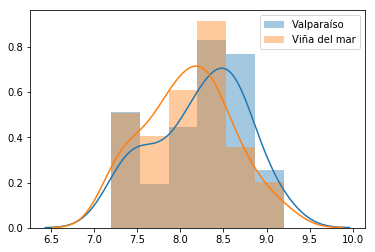

In [60]:
sns.distplot(valpoSeries, label = 'Valparaíso')
sns.distplot(vinaSeries, label = 'Viña del mar')
plt.legend()

It's possible to see in the above distribution graph, how the places to eat in Valparaíso (with a rating over 7.0) are in general in a much higer rating evaluation in comparision with Viña del mar.

In [77]:
print('Valparaíso has {} differents categories of places to eat: \n{} '.format(
    foodVenuesRatings[(foodVenuesRatings['City'] == 'Valparaíso') & (foodVenuesRatings['Rating'] >= 7.0)].loc[:,['Venue Category','Venue']].groupby('Venue Category').count().shape[0],
    foodVenuesRatings[(foodVenuesRatings['City'] == 'Valparaíso') & (foodVenuesRatings['Rating'] >= 7.0)].loc[:,['Venue Category','Venue']].groupby('Venue Category').count()))

Valparaíso has 23 differents categories of places to eat: 
                               Venue
Venue Category                      
Bar                                3
Bed & Breakfast                    2
Brewery                            1
Chinese Restaurant                 1
Coffee Shop                        3
Comfort Food Restaurant            1
Dessert Shop                       3
Falafel Restaurant                 1
Fast Food Restaurant               1
German Restaurant                  1
Ice Cream Shop                     2
Italian Restaurant                 2
Japanese Restaurant                2
Peruvian Restaurant                3
Pizza Place                        6
Pub                                1
Restaurant                         6
Sandwich Place                     2
Seafood Restaurant                 1
South American Restaurant          2
Tapas Restaurant                   1
Thai Restaurant                    1
Vegetarian / Vegan Restaurant      1 


In [76]:
print('Viña del mar has {} differents categories of places to eat: \n{}'.format(
    foodVenuesRatings[(foodVenuesRatings['City'] == 'Viña del mar') & (foodVenuesRatings['Rating'] >= 7.0)].loc[:,['Venue Category','Venue']].groupby('Venue Category').count().shape[0],
    foodVenuesRatings[(foodVenuesRatings['City'] == 'Viña del mar') & (foodVenuesRatings['Rating'] >= 7.0)].loc[:,['Venue Category','Venue']].groupby('Venue Category').count()))

Viña del mar has the 29 categories of places to eat: 
                           Venue
Venue Category                  
Asian Restaurant               1
Bagel Shop                     1
Bed & Breakfast                4
Beer Bar                       1
Beer Garden                    1
Breakfast Spot                 2
Brewery                        1
Burger Joint                   2
Coffee Shop                    6
Cupcake Shop                   1
Dessert Shop                   2
Diner                          1
Falafel Restaurant             1
Fast Food Restaurant           1
Hot Dog Joint                  1
Ice Cream Shop                 4
Indian Restaurant              1
Italian Restaurant             6
Juice Bar                      1
Latin American Restaurant      2
Mexican Restaurant             1
Peruvian Restaurant            2
Pizza Place                    4
Pub                            1
Public Art                     1
Restaurant                     3
Spanish Restaurant    

##### Which places are the top 10 in food ofering in general (Viña del mar & Valparaíso )?

In [16]:
foodVenuesRatings[foodVenuesRatings['Rating']>=7.0].sort_values(['Rating'], ascending=False).reset_index().head(10)

,index,City,Venue,Venue Latitude,Venue Longitude,Venue Category,Rating
0,53,Viña del mar,helados Coletti,-33.015976,-71.553024,Ice Cream Shop,9.2
1,58,Viña del mar,Don Vito e Zanoni,-33.014724,-71.554099,Italian Restaurant,9.2
2,19,Valparaíso,La Dulcería,-33.042442,-71.630630,Dessert Shop,9.2
3,9,Valparaíso,Malandrino,-33.043878,-71.628771,Pizza Place,9.1
4,0,Valparaíso,Hotzenplotz,-33.048339,-71.622510,German Restaurant,9.1
5,55,Viña del mar,Pizzeria Monte Amiata,-33.016756,-71.554636,Italian Restaurant,9.0
6,62,Viña del mar,Glasgow Pub,-33.015129,-71.553750,Beer Garden,8.9
7,2,Valparaíso,Sazón Nazca,-33.046749,-71.616066,Peruvian Restaurant,8.9
8,54,Viña del mar,San Romano,-33.017734,-71.555488,Pizza Place,8.8
9,18,Valparaíso,Brecon's,-33.041745,-71.628720,Pub,8.8


#### Conclusion
---
##### The city of Valparaíso has better ratings places to eat than Viña del Mar, However this difference is not huge enough, to make a clear winner. Viña del Mar shows as an city with also very good gastronomy as Valparaíso, but with more variety in styles and types of food, spread in a more big area than Valparíso.